<a href="https://colab.research.google.com/github/tanuja1521/project-A/blob/main/EMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load input data
input_data = pd.read_csv ('input.csv')
input_data

,t,Pl,G,Ps
0,1,1.45,2,0.0
1,2,1.31,2,0.0
2,3,1.21,2,0.0
3,4,1.16,2,0.0
4,5,1.15,2,0.0
...,...,...,...,...
62,68,2.20,4,0.0
63,69,2.09,4,0.0
64,70,1.93,2,0.0
65,71,1.72,2,0.0


In [3]:
# Determine Price Ranges and Battery Modes
max_price = input_data['G'].max()

conditions = [
    (input_data['G'] <= 0.5*max_price),
    (input_data['G'] > 0.5*max_price) & (input_data['G'] <= 0.6*max_price),
    (input_data['G'] > 0.6*max_price) & (input_data['G'] <= 0.8*max_price),
    (input_data['G'] > 0.8*max_price)
    ]

price_range = ['low', 'medium', 'high', 'very high']
state = ['C','C', 'D', 'D']

input_data['PR'] = np.select(conditions, price_range)
input_data['BM'] = np.select(conditions, state)

input_data

,t,Pl,G,Ps,PR,BM
0,1,1.45,2,0.0,low,C
1,2,1.31,2,0.0,low,C
2,3,1.21,2,0.0,low,C
3,4,1.16,2,0.0,low,C
4,5,1.15,2,0.0,low,C
...,...,...,...,...,...,...
62,68,2.20,4,0.0,medium,C
63,69,2.09,4,0.0,medium,C
64,70,1.93,2,0.0,low,C
65,71,1.72,2,0.0,low,C


In [4]:
n = 0.9 #Efficiency of charging or discharging
Pbat = 2 #Maximum charging rate
c = 0

# Calculating Powerflow to battery
def P_bat(i, PR):
  global c
  if i == 0:
    return 0
  elif PR == 'very high':
    c = 0
    return abs(input_data.loc[i,'Ps'] - input_data.loc[i,'Pl'])
  elif PR == 'high':
    c = 0
    return 0.8*abs(input_data.loc[i,'Ps'] - input_data.loc[i,'Pl'])
  else:
    c+=1
    if PR == 'low':
      return Pbat*pow(n,c)
    else:
      return 0.5*Pbat*pow(n,c)
input_data['Pb'] = input_data.apply(lambda x: P_bat(x.name, x['PR']), axis=1)

In [5]:
prevCharge = 1.8

#Calculating Energy stored in battery and check the rules
def E_bat(i, Pbat, BM):
  a = 1 if BM=='C' else -1
  global prevCharge
  if prevCharge + pow(n,a)*a*Pbat>=0 and prevCharge + pow(n,a)*a*Pbat<=10:
      prevCharge += pow(n,a)*a*Pbat
  else:
    input_data.loc[i,'BM']='I'
    input_data.loc[i,'Pb']=0
  return prevCharge

input_data['Eb'] = input_data.apply(lambda x: E_bat(x.name,x['Pb'], x['BM']),axis = 1)
input_data

,t,Pl,G,Ps,PR,BM,Pb,Eb
0,1,1.45,2,0.0,low,C,0.00000,1.800000
1,2,1.31,2,0.0,low,C,1.80000,3.420000
2,3,1.21,2,0.0,low,C,1.62000,4.878000
3,4,1.16,2,0.0,low,C,1.45800,6.190200
4,5,1.15,2,0.0,low,C,1.31220,7.371180
...,...,...,...,...,...,...,...,...
62,68,2.20,4,0.0,medium,C,0.90000,3.188535
63,69,2.09,4,0.0,medium,C,0.81000,3.917535
64,70,1.93,2,0.0,low,C,1.45800,5.229735
65,71,1.72,2,0.0,low,C,1.31220,6.410715


In [6]:
input_data['Pg'] = input_data.apply(lambda x:x['Pl']-x['Ps']+x['Pb'] if x['BM'] == 'C' else x['Pl']-x['Ps']-x['Pb'], axis=1) #Total power flow from grid
input_data['U'] = input_data.apply(lambda x:x['Pl']*x['G'], axis=1) #Net amount without solar
input_data['Uw'] = input_data.apply(lambda x:x['Pg']*x['G'], axis=1) #Net amount with solar and energy storage
input_data['Us'] = input_data.apply(lambda x:(x['Pl']-x['Ps'])*x['G'], axis=1) #Net amount with solar and without energy storage
input_data

,t,Pl,G,Ps,PR,BM,Pb,Eb,Pg,U,Uw,Us
0,1,1.45,2,0.0,low,C,0.00000,1.800000,1.45000,2.90,2.90000,2.90
1,2,1.31,2,0.0,low,C,1.80000,3.420000,3.11000,2.62,6.22000,2.62
2,3,1.21,2,0.0,low,C,1.62000,4.878000,2.83000,2.42,5.66000,2.42
3,4,1.16,2,0.0,low,C,1.45800,6.190200,2.61800,2.32,5.23600,2.32
4,5,1.15,2,0.0,low,C,1.31220,7.371180,2.46220,2.30,4.92440,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...
62,68,2.20,4,0.0,medium,C,0.90000,3.188535,3.10000,8.80,12.40000,8.80
63,69,2.09,4,0.0,medium,C,0.81000,3.917535,2.90000,8.36,11.60000,8.36
64,70,1.93,2,0.0,low,C,1.45800,5.229735,3.38800,3.86,6.77600,3.86
65,71,1.72,2,0.0,low,C,1.31220,6.410715,3.03220,3.44,6.06440,3.44


In [7]:
input_data.to_csv('output.csv',encoding='utf-8', index=False, float_format='%.3f')

In [8]:
S = input_data['Us'].sum() - input_data['Uw'].sum() # The net saving in the bill
print("The net savings in the bill for 3 days,", S) 

The net savings in the bill for 3 days, 57.96532503371594


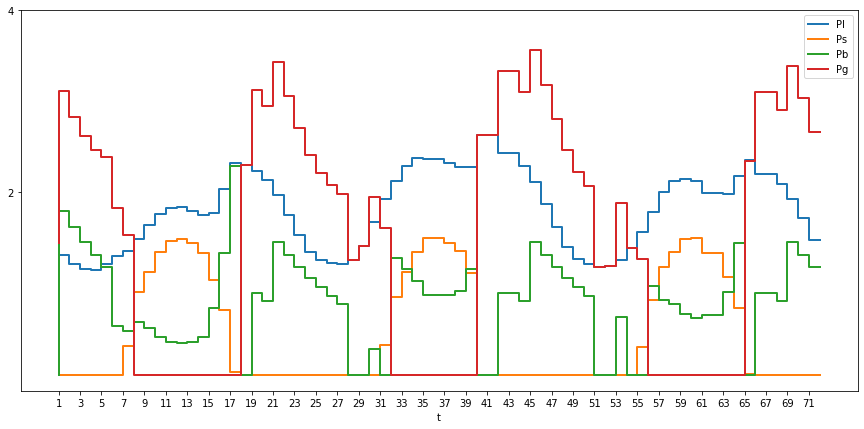

In [9]:
input_data.plot(drawstyle="steps",x="t", y=["Pl", "Ps", "Pb", "Pg"],linewidth=2.0, figsize=(15, 7))
plt.xticks(np.arange(1, 72, 2))    # changing x scale by own
plt.yticks([2, 4])
plt.show()